# **Classifying Clothing Images**

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# GPU check
import psutil
import os

torch.cuda.is_available()

True

In [3]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [4]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [19]:
images[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

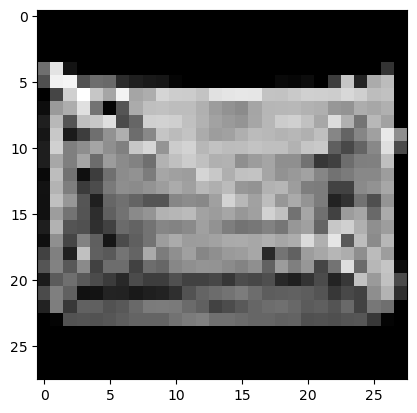

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [7]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(
                      nn.Flatten(),
                      nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

# Define the epochs
epochs = 10

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10.. Training loss: 0.589.. Test loss: 0.454.. Test Accuracy: 0.828
Epoch: 2/10.. Training loss: 0.433.. Test loss: 0.405.. Test Accuracy: 0.857
Epoch: 3/10.. Training loss: 0.400.. Test loss: 0.400.. Test Accuracy: 0.857
Epoch: 4/10.. Training loss: 0.380.. Test loss: 0.371.. Test Accuracy: 0.866
Epoch: 5/10.. Training loss: 0.363.. Test loss: 0.381.. Test Accuracy: 0.860
Epoch: 6/10.. Training loss: 0.354.. Test loss: 0.365.. Test Accuracy: 0.867
Epoch: 7/10.. Training loss: 0.340.. Test loss: 0.359.. Test Accuracy: 0.871
Epoch: 8/10.. Training loss: 0.334.. Test loss: 0.342.. Test Accuracy: 0.880
Epoch: 9/10.. Training loss: 0.329.. Test loss: 0.346.. Test Accuracy: 0.878
Epoch: 10/10.. Training loss: 0.322.. Test loss: 0.347.. Test Accuracy: 0.877


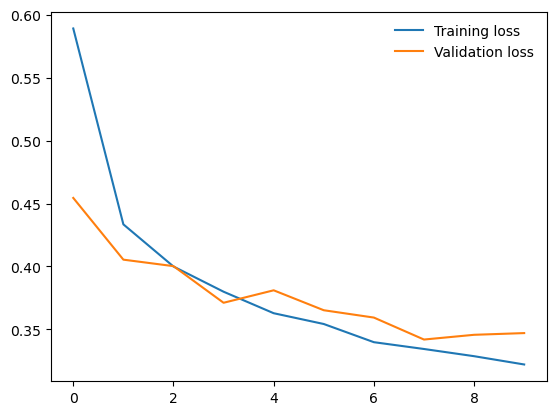

In [8]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

### Serialize the model

In [17]:
example = torch.rand(1, 1, 28, 28)
model.eval()
print(model.forward(example))

tensor([[-9.7603e+00, -2.2494e+01, -1.4651e+01, -1.8449e+01, -1.5274e+01,
         -2.5272e+01, -7.9596e+00, -2.5687e+01, -4.0773e-04, -2.2606e+01]],
       grad_fn=<LogSoftmaxBackward0>)


In [9]:
traced_module = torch.jit.trace(model, example)
traced_module.save("dummy_model.pt")

In [15]:
import os
os.getcwd()

'/home/tomek/zpr/24l-zpr'